# __Step 6 Analyses of models and predictions__

Goals: I am interested in:
- Model interpretation
  - Figure out how top words that define plant sciences are related to each other. 
  - See if there is certain date range, journal are more challenging to predict.

Main questions:
- What is the overall performance of model?
- What features are important for predictions?
- What are the reasons for mispredictions?
  - Are there any patterns among predicted instances?
  - E.g., publication date, journal.
- How are the article related to each other in the W2V space?
  - We have the vecortized document. Can plot them with tSNE to see how TP, FP, FN, and TN are distributed.

Also for interpretability purpose:
- Tf-Idf with `[max_features, ngram_range, p_threshold]=[10000.0, (1, 3), 0.01]` are also examined.
- This is because the Tf-Idf values is immediately interpretable and the model is based on XGBoost and I can get feature importance using SHAP.

## ___Setup___

### Import

In [1]:
# Added this line, otherwise tqdm complained about jupyter and ipywidgets need
# to be updated, see:
# https://stackoverflow.com/questions/67998191/importerror-iprogress-not-found-please-update-jupyter-and-ipywidgets-although
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
import json
import pickle
import joblib
import shap  # 07/03/22: conda install lead to conflict, use pip instead
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from pathlib import Path
from sklearn import metrics, manifold, inspection
import script_2_3_text_classify_w2v as script23

ImportError: Numba needs NumPy 1.21 or less

### Configurations

In [29]:
rand_state   = 20220609

work_dir     = Path.home() / 'projects/plant_sci_hist/2_text_classify'
corpus_combo = work_dir / "corpus_combo"


# training corpus
corpus_train_file = work_dir / 'corpus_train_ori.tsv.gz'

dir_22 = work_dir / "2_2_model_tf_tfidf"
dir_23 = work_dir / "2_3_model_w2v"
dir_26 = work_dir / "2_6_model_interpret"

dir_26.mkdir(exist_ok=True)

# Trainded Word2Vec model, tokenizer, and vocab for getting embeddings
w2v_name   = dir_23 / "model_cln_w2v_20-8-3"
tok_name   = dir_23 / "model_cln_w2v_token_20-8-3"
vocab_name = dir_23 / "model_cln_w2v_vocab_20-8-3"

# w2v model predictions
train_pred   = dir_23 / "corpus_train_pred"
valid_pred   = dir_23 / "corpus_valid_pred"
test_pred    = dir_23 / "corpus_test_pred"

# W2V DNN checkpoint path
cp_filepath = dir_23 / "model_cln_w2v_20-8-3_dnn"

# For Tf
## Tf model
tf_model_file = dir_22 / "model_ori_tf_1000-1to2-0.0001.sav"
## vectorizer
corpus_train_tf_vec_file = dir_22 / \
                        "corpus_ori_tf_1000-1to2-0.0001_vec_sel.pkl"
## selected, vecterized features
corpus_train_tf_vec_sel_file = dir_22 / \
                        "corpus_ori_tf_1000-1to2-0.0001_train_vec_sel.json"

# For Tf-idf
## Tf-idf model: the name 1000 is a bit strange, CHECK
tfidf_model_file = dir_22 / "model_ori_tf-idf_1000-1to2-0.0001.sav"
## vectorizer
corpus_train_tfidf_vec_file = dir_22 / \
                        "corpus_ori_tf-idf_1000-1to2-0.0001_vec_sel.pkl"
## selected, vecterized features
corpus_train_tfidf_vec_sel_file = dir_22 / \
                        "corpus_ori_tf-idf_1000-1to2-0.0001_train_vec_sel.json"

# Getting ngrams
ngram = 3
min_count = 20

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

NameError: name 'mpl' is not defined

In [4]:
def json_to_df(json_file):
  with json_file.open("r+") as f:
      json_loaded = json.load(f)
  df = pd.read_json(json_loaded)
  
  return df

## ___W2V model performance___

### Consolidate predictions with original dataframe

In [5]:
# Get the original corpus
corpus_ori = json_to_df(corpus_combo)
corpus_ori.shape

(86646, 9)

In [6]:
# Load the prediction TSV files as dataframes
train_pred_df = pd.read_csv(train_pred, sep='\t', index_col=0)
valid_pred_df = pd.read_csv(valid_pred, sep='\t', index_col=0)
test_pred_df  = pd.read_csv(test_pred , sep='\t', index_col=0)

In [7]:
train_pred_df["subset"] = "train"
valid_pred_df["subset"] = "valid"
test_pred_df["subset"]  = "test"

In [8]:
train_pred_df.sample(3)

,y,y_pred,y_prob,X,subset
1351530,1,1,0.988944,fruit leaf response different sourcesink ratio...,train
568411,0,0,0.080125,epitope mapping pr81 antimuc1 monoclonal antib...,train
397679,0,0,0.000403,maple syrup disease standard nursing care mapl...,train


In [9]:
# Make sure the indices between two dataframes are consistent
print(train_pred_df.loc[271250].X[:100])
print(corpus_ori.loc[271250].txt[:100])

nuclear pore complex nuclear pore complex largest supramolecular complex assembles eukaryotic cell s
The nuclear pore complex.. The nuclear pore complex is the largest supramolecular complex that assem


In [10]:
# Make sure the indices between two dataframes are consistent
print(train_pred_df.loc[583057].X[:100])
print(corpus_ori.loc[583057].txt[:100])

difference universal diverse orientation among nursing student australia globalization intensified m
Differences in universal diverse orientation among nursing students in Australia.. With globalizatio


In [11]:
# Concatenate prediction dataframes
pred_df = pd.concat([train_pred_df, valid_pred_df, test_pred_df])
pred_df.shape

(86646, 5)

In [12]:
pred_df.head()

,y,y_pred,y_prob,X,subset
516651,1,1,0.982180,vivo vitro inhibition catalase leaf nicotiana ...,train
521301,1,1,0.993828,pathway glucose regulation monosaccharide tran...,train
65516,0,0,0.001417,feasibility home treatment diarrhoea packaged ...,train
277058,1,1,0.990589,modulation phosphatidylcholine biosynthesis ce...,train
753225,1,1,0.921157,120yr period dr beals seed viability experimen...,train


In [13]:
# Concatenate prediction dataframe and the original dataframe
combo_pred = pd.concat([corpus_ori, pred_df], axis=1)
combo_pred.head(2)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,label,txt_clean,y,y_pred,y_prob,X,subset
600447,18467466,2008-05-10,Plant physiology,The Arabidopsis halophytic relative Thellungie...,A comprehensive knowledge of mechanisms regula...,plant,The Arabidopsis halophytic relative Thellungie...,1,arabidopsis halophytic relative thellungiella ...,1,1,0.993899,arabidopsis halophytic relative thellungiella ...,train
583302,18065557,2007-12-11,Plant physiology,An Arabidopsis purple acid phosphatase with ph...,Ascorbate (AsA) is the most abundant antioxida...,plant,An Arabidopsis purple acid phosphatase with ph...,1,arabidopsis purple acid phosphatase phytase ac...,1,1,0.995514,arabidopsis purple acid phosphatase phytase ac...,train


In [14]:
# Check the label and y columns again to make sure they are exactly the same
combo_pred['label'].equals(combo_pred['y'])

True

In [15]:
# Drop the uncessary columns
combo_pred = combo_pred.drop(['txt', 'txt_clean', 'y', 'X'], axis=1)
combo_pred.head(2)

,PMID,Date,Journal,Title,Abstract,QualifiedName,label,y_pred,y_prob,subset
600447,18467466,2008-05-10,Plant physiology,The Arabidopsis halophytic relative Thellungie...,A comprehensive knowledge of mechanisms regula...,plant,1,1,0.993899,train
583302,18065557,2007-12-11,Plant physiology,An Arabidopsis purple acid phosphatase with ph...,Ascorbate (AsA) is the most abundant antioxida...,plant,1,1,0.995514,train


In [16]:
combo_pred_json = combo_pred.to_json()
combo_pred_json_file = dir_26 / 'corpus_combo_pred.json'
with combo_pred_json_file.open("w+") as f:
  json.dump(combo_pred_json, f)

### Get confusion matrix

Confusion matrix:
- tn: 41327
- fp: 1996
- fn: 888
- tp: 42435

In [17]:
def get_confusion_matrix(df, subset=""):
  if subset == "":
    y_true = df['label'].values
    y_pred = df['y_pred'].values
  else:
    y_true = df[df['subset'] == subset]['label'].values
    y_pred = df[df['subset'] == subset]['y_pred'].values

  tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

  print("number of instances:", sum([tn, fp, fn, tp]))

  return tn, fp, fn, tp

In [18]:
# overall tn, fp, fn, tp
get_confusion_matrix(combo_pred, subset="")

number of instances: 86646


(41327, 1996, 888, 42435)

In [19]:
# validation tn, fp, fn, tp
get_confusion_matrix(combo_pred, subset="valid")

number of instances: 17329


(8244, 420, 209, 8456)

In [20]:
# testing tn, fp, fn, tp
get_confusion_matrix(combo_pred, subset="test")

number of instances: 17330


(8211, 454, 228, 8437)

### Get prediction probability distributions of tp, tn, fp, fn

In [21]:
c_true = combo_pred['label']  # column for true label
c_pred = combo_pred['y_pred'] # column for predicted label
subset = combo_pred['subset'] # column with subset info
combo_test_tp = combo_pred[(c_true == 1) & (c_pred == 1) & (subset == "test")]
combo_test_tp.shape # Expected 8437 instances

(8437, 10)

In [22]:
combo_test_tn = combo_pred[(c_true == 0) & (c_pred == 0) & (subset == "test")]
combo_test_fp = combo_pred[(c_true == 0) & (c_pred == 1) & (subset == "test")]
combo_test_fn = combo_pred[(c_true == 1) & (c_pred == 0) & (subset == "test")]
# Expected tn=8211, fp=454, fn=228
combo_test_tn.shape, combo_test_fp.shape, combo_test_fn.shape

((8211, 10), (454, 10), (228, 10))

In [23]:
# Add another column, labeling TP, FP, TN, FN
true_vs_pred = []
for i in range(len(c_true)):
  if c_true.iloc[i] == 1 and c_pred.iloc[i] == 1:
    true_vs_pred.append("TP")
  elif c_true.iloc[i] == 1 and c_pred.iloc[i] == 0:
    true_vs_pred.append("FN")
  elif c_true.iloc[i] == 0 and c_pred.iloc[i] == 0:
    true_vs_pred.append("TN")
  elif c_true.iloc[i] == 0 and c_pred.iloc[i] == 1:
    true_vs_pred.append("FP")
  else:
    print("This should not happen...")

In [24]:
combo_pred["true_vs_pred"] = true_vs_pred
combo_pred[(combo_pred["subset"] == "test")].shape

(17330, 11)

In [25]:
# Dataframe of test set with positive labels
test_pos = combo_pred[(combo_pred["subset"] == "test") &
                      ((combo_pred["true_vs_pred"] == "TP") |
                       (combo_pred["true_vs_pred"] == "FN"))]
# Test set with negative labels
test_neg = combo_pred[(combo_pred["subset"] == "test") &
                      ((combo_pred["true_vs_pred"] == "TN") |
                       (combo_pred["true_vs_pred"] == "FP"))]                      

In [26]:
test_pos.shape, test_neg.shape

((8665, 11), (8665, 11))

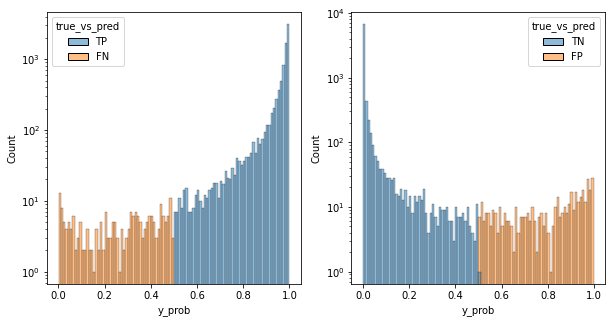

In [31]:
# log scale: 
# https://seaborn.pydata.org/generated/seaborn.histplot.html
# Save figure
# https://www.marsja.se/how-to-save-a-seaborn-plot-as-a-file-e-g-png-pdf-eps-tiff/
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(data=test_pos, ax=ax1, x="y_prob", hue="true_vs_pred",
             bins=100, log_scale=(False, True))
sns.histplot(data=test_neg, ax=ax2, x="y_prob", hue="true_vs_pred",
             bins=100, log_scale=(False, True))
plt.savefig(dir_26 / 'figure_corpus_test_w2v_pred_prob_log.pdf')

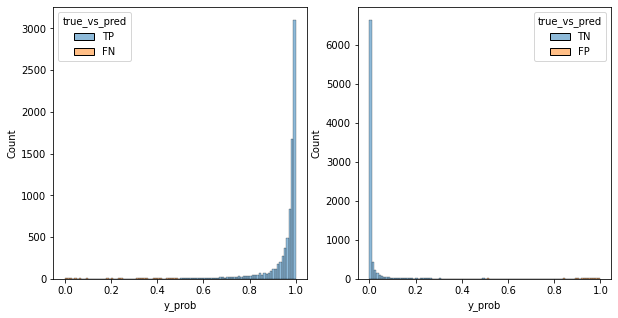

In [32]:
# Problem with very long bars extending beyond the bound of the graphwhen logged
# Draw non-logged version instead
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(data=test_pos, ax=ax1, x="y_prob", hue="true_vs_pred",
             bins=100, log_scale=(False, False))
sns.histplot(data=test_neg, ax=ax2, x="y_prob", hue="true_vs_pred",
             bins=100, log_scale=(False, False))
plt.savefig(dir_26 / 'figure_corpus_test_w2v_pred_prob.pdf')

### Get the embeddings for the dataset

In [28]:
# Load word2vec model
with open(w2v_name, "rb") as f:
  model_w2v = pickle.load(f)
model_w2v

# Load tokenzier and vocab
with open(tok_name, "rb") as f:
  tokenizer = pickle.load(f)

with open(vocab_name, "rb") as f:
  vocab = pickle.load(f)

In [29]:
# Combine title and abstract
combo_pred_corpus = combo_pred['Title'] + combo_pred['Abstract']
type(combo_pred_corpus), combo_pred_corpus.shape

(pandas.core.series.Series, (86646,))

In [30]:
embeddings, X_w2v = script23.get_embeddings(combo_pred_corpus, model_w2v, 
                                            tokenizer, vocab)

In [31]:
embeddings.shape, X_w2v.shape

((398412, 300), (86646, 500))

In [32]:
# Check that the X_w2v is alright by making predictions
model_emb = tf.keras.models.load_model(cp_filepath)

2022-07-07 09:18:59.062362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 09:18:59.063801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 09:18:59.064278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 09:18:59.064941: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [33]:
# predict the 1st 10 instances
model_emb.predict(X_w2v[:10]), combo_pred['label'][:10]

2022-07-07 09:19:27.448185: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-07-07 09:19:29.021871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


(array([[0.0249758 , 0.9750242 ],
        [0.01043593, 0.98956406],
        [0.06747952, 0.93252045],
        [0.07229093, 0.9277091 ],
        [0.01478202, 0.985218  ],
        [0.06229234, 0.93770766],
        [0.00907795, 0.99092203],
        [0.12365308, 0.8763469 ],
        [0.10641314, 0.8935868 ],
        [0.02975632, 0.97024363]], dtype=float32),
 600447     1
 583302     1
 1267478    1
 241978     1
 917182     1
 514191     1
 814841     1
 960330     1
 1049205    1
 1304774    1
 Name: label, dtype: int64)

In [34]:
# predict the last 10 instances
model_emb.predict(X_w2v[-10:]), combo_pred['label'][-10:]

(array([[0.9945773 , 0.00542274],
        [0.9464639 , 0.05353615],
        [0.99600047, 0.00399954],
        [0.9935493 , 0.00645074],
        [0.99700075, 0.00299922],
        [0.9979448 , 0.00205525],
        [0.9956126 , 0.00438734],
        [0.9980108 , 0.00198924],
        [0.99889684, 0.00110317],
        [0.99846506, 0.001535  ]], dtype=float32),
 980575     0
 980576     0
 1004619    0
 1059770    0
 1189748    0
 1211506    0
 1316707    0
 1340192    0
 1401355    0
 1411052    0
 Name: label, dtype: int64)

## ___Interpreting Tf model___

### Get model, corpus, vectorizer, and vocab

In [35]:
# Load model
tf_model = joblib.load(tf_model_file)

In [36]:
# Read training data
corpus_train = pd.read_csv(corpus_train_file, sep="\t", compression='gzip',
                           index_col=0)
corpus_train.shape

(69316, 2)

In [37]:
# Load vectorizer
with open(corpus_train_tf_vec_file, 'rb') as f:
  tf_vec = pickle.load(f)

In [38]:
# transform corpus with vectorizer
X_tf_vec = tf_vec.transform(corpus_train['txt'])
X_tf_vec.shape

(69316, 899)

In [39]:
# Get vocab: 899 of them
tf_vec_vocab = tf_vec.vocabulary_
len(tf_vec_vocab.keys())

899

In [40]:
tf_feat_names = list(tf_vec_vocab.keys())
type(tf_feat_names), len(tf_feat_names)

(list, 899)

### Get y_prob and y_pred

In [41]:
# Get prediction probability
y_prob_tf = tf_model.predict_proba(X_tf_vec)
# Get predictions
y_pred_tf = tf_model.predict(X_tf_vec)
# Specify true label
y_true_tf = corpus_train['label']

In [42]:
metrics.f1_score(y_true_tf, y_pred_tf)

0.9416044855972949

In [48]:
type(X_tf_vec), X_tf_vec.shape, len(tf_feat_names)

(scipy.sparse.csr.csr_matrix, (69316, 899), 899)

In [49]:
# Set up input data
X_tf_vec_df = pd.DataFrame.sparse.from_spmatrix(X_tf_vec, columns=tf_feat_names)
X_tf_vec_df.shape

(69316, 899)

### Get permuation importance

___DID NOT WORK!!!!!___

In [ ]:
# Get permutation importance
# https://mljar.com/blog/feature-importance-xgboost/

# call sklearn.inspection.permutation_importance
# This takes a while: ~2 hours

# AND IT DID NOT WORK!!
tf_perm_imp = inspection.permutation_importance(tf_model, X_tf_vec_df, y_true_tf)

In [ ]:
tf_perm_imp

### Get Xgboost importance

In [43]:
# Unsure what the values means...
tf_importances = tf_model.feature_importances_
type(tf_importances), tf_importances.shape

(numpy.ndarray, (899,))

### Get SHAP importance

In [44]:
# Provide feature names
#https://stackoverflow.com/questions/46943314/xgboost-plot-importance-doesnt-show-feature-names
tf_model.get_booster().feature_names = tf_feat_names

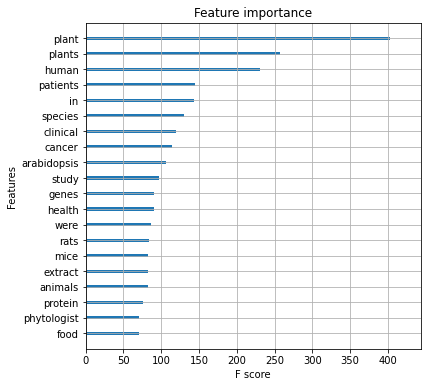

In [45]:
# Plot importance
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.plotting
fig_xgb_imp_weight_file = dir_26 /'figure_tf_model_imp_xgb_weight_20.pdf'

plt.rcParams["figure.figsize"] = (6, 6)
xgb.plot_importance(tf_model, max_num_features=20, show_values=False)
plt.savefig(fig_xgb_imp_weight_file)

In [46]:
# The above is not particularly helpful, need info on direction of importance
# So use 
tf_explainer = shap.TreeExplainer(tf_model)
type(tf_explainer)

shap.explainers._tree.Tree

In [50]:
# ~2 min
tf_shap_val = tf_explainer.shap_values(X_tf_vec_df)
len(tf_shap_val), len(tf_shap_val[0])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(69316, 899)

In [58]:
# mean shap values for each feature as importance
tf_imp_vals = list(tf_shap_val.sum(axis=0)/len(tf_shap_val[0]))

In [62]:
type(tf_feat_names), len(tf_feat_names), type(tf_imp_vals), len(tf_imp_vals)

(list, 899, list, 899)

In [87]:
# Save shap values into a file
tf_imp_df = pd.DataFrame(list(zip(tf_feat_names, tf_imp_vals)), 
                          columns=['feat_name', 'imp_vals'])
tf_imp_df_file = dir_26 / 'model_tf_shap_importance.tsv'    
tf_imp_df.to_csv(tf_imp_df_file, sep='\t')

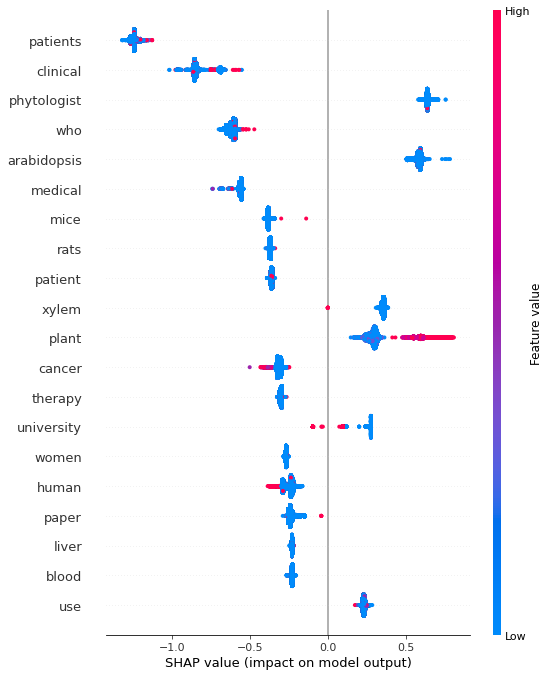

<Figure size 432x432 with 0 Axes>

In [82]:
shap.summary_plot(tf_shap_val, X_tf_vec_df)
fig_tf_shap_importance = dir_26 /'figure_tf_model_shap.pdf'
plt.savefig(fig_tf_shap_importance)

### Figure out relationship between importance values

In [83]:
tf_imp_vals2 = tf_model.feature_importances_
tf_imp_vals2[:10]

array([0.        , 0.        , 0.00037428, 0.        , 0.        ,
       0.00066925, 0.0001812 , 0.        , 0.        , 0.000507  ],
      dtype=float32)

In [85]:
tf_imp_vals[:10]

[0.0,
 0.0,
 -0.18123986,
 0.0,
 0.0,
 -1.7836432,
 -0.004720065,
 0.0,
 0.0,
 -0.7475949]

## ___Interpreting Tf-idf model___

### Get model, corpus, vectorizer, and vocab

In [68]:
# Load model
tfidf_model = joblib.load(tfidf_model_file)

In [69]:
# Load vectorizer
with open(corpus_train_tfidf_vec_file, 'rb') as f:
  tfidf_vec = pickle.load(f)

In [70]:
# transform corpus with vectorizer
X_tfidf_vec = tfidf_vec.transform(corpus_train['txt'])
X_tfidf_vec.shape

(69316, 639)

In [71]:
# Get vocab: 899 of them
tfidf_vec_vocab = tfidf_vec.vocabulary_
len(tfidf_vec_vocab.keys())

639

In [72]:
tfidf_feat_names = list(tfidf_vec_vocab.keys())

### Get y_prob and y_pred

In [73]:
# Get prediction probability
y_prob_tfidf = tfidf_model.predict_proba(X_tfidf_vec)
# Get predictions
y_pred_tfidf = tfidf_model.predict(X_tfidf_vec)
# Specify true label
y_true_tfidf = corpus_train['label']

In [74]:
metrics.f1_score(y_true_tfidf, y_pred_tfidf)

0.9412654254939724

### Get SHAP importance

In [75]:
# Unsure what the values means...
tfidf_importances = tfidf_model.feature_importances_
type(tfidf_importances), tfidf_importances.shape

(numpy.ndarray, (639,))

In [76]:
# Provide feature names
#https://stackoverflow.com/questions/46943314/xgboost-plot-importance-doesnt-show-feature-names
tfidf_model.get_booster().feature_names = tfidf_feat_names

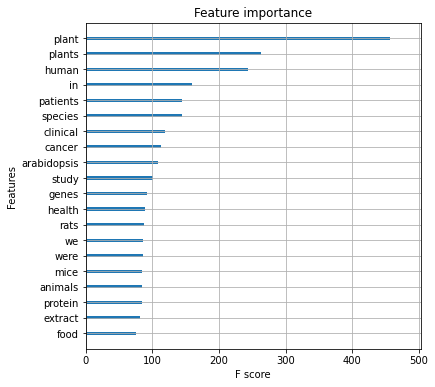

In [77]:
# Plot importance
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.plotting
fig_xgb_imp_weight_file_tfidf = dir_26/ \
                                    'figure_tfidf_model_imp_xgb_weight_20.pdf'

plt.rcParams["figure.figsize"] = (6, 6)
xgb.plot_importance(tfidf_model, max_num_features=20, show_values=False)
plt.savefig(fig_xgb_imp_weight_file_tfidf)

In [78]:
# The above is not particularly helpful, need info on direction of importance
# So use 
tfidf_explainer = shap.TreeExplainer(tfidf_model)
type(tf_explainer)

shap.explainers._tree.Tree

In [79]:
# ~2 min
X_tfidf_vec_df = pd.DataFrame.sparse.from_spmatrix(X_tfidf_vec, 
                                                   columns=tfidf_feat_names)

tfidf_shap_val = tfidf_explainer.shap_values(X_tfidf_vec_df)
len(tfidf_shap_val), len(tfidf_shap_val[0])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(69316, 639)

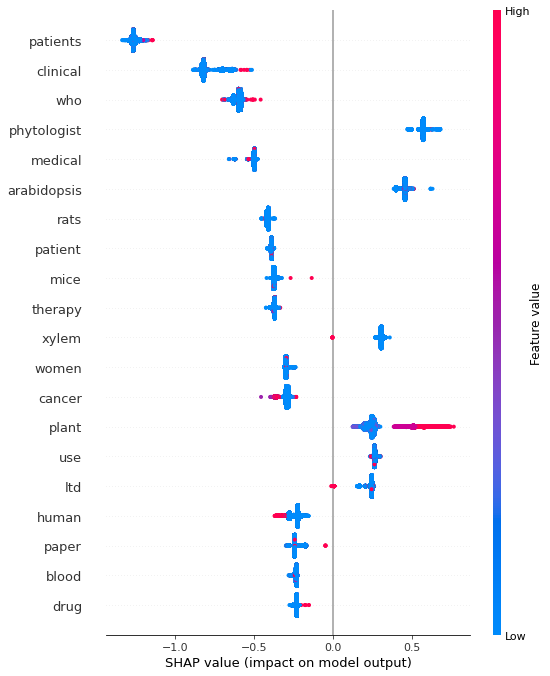

<Figure size 432x432 with 0 Axes>

In [80]:
shap.summary_plot(tfidf_shap_val, X_tfidf_vec_df)
fig_tfidf_shap_importance = dir_26 /'figure_tfidf_model_shap.pdf'
plt.savefig(fig_tfidf_shap_importance)

In [88]:
# mean shap values for each feature as importance
tfidf_imp_vals = list(tfidf_shap_val.sum(axis=0)/len(tfidf_shap_val[0]))

# Save shap values into a file
tfidf_imp_df = pd.DataFrame(list(zip(tfidf_feat_names, tfidf_imp_vals)), 
                          columns=['feat_name', 'imp_vals'])
tfidf_imp_df_file = dir_26 / 'model_tfidf_shap_importance.tsv'    
tfidf_imp_df.to_csv(tfidf_imp_df_file, sep='\t')

## ___For testing___

### Add an incorrect column and get all the wrongly predicted entries

In [ ]:
incorrect = [val_l[i] != val_y[i] for i in range(len(val_l)) ]

In [ ]:
combo_pred['incorrect'] = incorrect
combo_pred.shape

In [ ]:
combo_pred_wrong = combo_pred[incorrect]
combo_pred_wrong.shape

In [ ]:
combo_pred_wrong.sample(2)

### Plot prediction proab

In [ ]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(combo_test_tp["y_prob"]), bw_method=0.5)
sns.kdeplot(np.array(combo_test_fp["y_prob"]), bw_method=0.5)
sns.kdeplot(np.array(combo_test_tn["y_prob"]), bw_method=0.5)
sns.kdeplot(np.array(combo_test_fn["y_prob"]), bw_method=0.5)

Problem with the above plot is that the distributions are fitted and value ranges are not correct.

In [ ]:
fig, axs = plt.subplots(2, 2)
bins = np.linspace(0, 1, 100)
fig.suptitle('Prediction probabilities')
axs[0,0].hist(combo_test_tp["y_prob"], bins, alpha=0.5)
axs[0,0].legend("TP", loc="upper center")
axs[0,1].hist(combo_test_tn["y_prob"], bins, alpha=0.5)
axs[0,1].legend("TN ", loc="upper center")
axs[1,0].hist(combo_test_fp["y_prob"], bins, alpha=0.5)
axs[1,0].legend("FP ", loc="upper center")
axs[1,1].hist(combo_test_fn["y_prob"], bins, alpha=0.5)
axs[1,1].legend("FN ", loc="upper center")
plt.show()

... Can do better.

In [ ]:
sns.histplot(data=combo_pred[combo_pred["subset"] == "test"],
             x="y_prob", 
             hue="true_vs_pred",
             stat="density",
             common_norm=False,
             bins=100, alpha=0.5)

### tSNE plot

Used X_w2v for this, they don't separate well and it makes sense. X_w2v contains the tokenized text converted to token indices and they are of various lengths depending of the lengths of texts. Fo text shorter than 500 words, they are padded. So I cannot expect such index value vectors to be correlated between citations. Would make more sense if this is done using doc2vec instead of word2vec for this purpose.

In [ ]:
# https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# Take ~16 min

n_components = 2
tsne         = manifold.TSNE(n_components, init='pca', learning_rate='auto')
tsne_result  = tsne.fit_transform(X_w2v)

In [ ]:
tsne_result.shape

In [ ]:
# Generate tSNE plot based on label
label = combo_pred['label']

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 
                               'tsne_2': tsne_result[:,1], 
                               'label': label})

tsne_result_df_sample = tsne_result_df.sample(10000)

fig, ax = plt.subplots(1, figsize=(10,5))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', ax=ax, s=2, alpha=0.2,
                data=tsne_result_df_sample)
#lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim((-2e5, 4e5))
ax.set_ylim((-3e5, 3e5))
ax.set_aspect('equal')
plt.savefig(work_dir / 'figure_corpus_w2v_tsne_label.pdf')

In [ ]:
# bin the pred_prob column to used as hue
bins = [bin*0.20 for bin in range(0,6)]
bin_labels = range(0,5)
print(len(bins), len(bin_labels))
pred_prob_bins = pd.cut(combo_pred['y_prob'], bins=bins, labels=bin_labels)
pred_prob_bins.value_counts()

In [ ]:
tsne_result_df2 = pd.DataFrame({'tsne_1': tsne_result[:,0], 
                                'tsne_2': tsne_result[:,1], 
                                'label': pred_prob_bins})

tsne_result_df2_sample = tsne_result_df2.sample(10000)

fig, ax = plt.subplots(1, figsize=(10,5))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', ax=ax, s=2, alpha=0.2,
                data=tsne_result_df2_sample)
#lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim((-2e5, 4e5))
ax.set_ylim((-3e5, 3e5))
ax.set_aspect('equal')
plt.savefig(work_dir / 'figure_corpus_w2v_tsne_prob.pdf')